<a href="https://colab.research.google.com/github/ErickMartinezz/AprendizajeAutomatico2/blob/main/TP5_RL2_ErickMartinez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico: Aprendizaje por Refuerzo en highway-v0

## Instalacion de librerias

In [1]:
!pip install -q highway-env gymnasium stable-baselines3 pygame
# Si luego usás algoritmos de sb3-contrib, agregá:
!pip install -q sb3-contrib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 4.2 MB/s eta 0:00:00


## Reproducibilidad y creacion del entorno


In [2]:
import numpy as np
import random
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seed establecida: {seed}")

SEED = 42
set_seed(SEED)

Seed establecida: 42


In [3]:
import gymnasium as gym
import highway_env

def make_env(seed=SEED, render_mode=None):
    env = gym.make("highway-v0", render_mode=render_mode)
    env.unwrapped.config.update({
        "lanes_count": 4,
        "vehicles_count": 20,
        "duration": 40,
        "policy_frequency": 15,
        "collision_reward": -1.0,
        "high_speed_reward": 0.4,
        "reward_speed_range": [20, 30],
        "observation": {
            "type": "Kinematics",
            "features": ["x", "y", "vx", "vy"],
            "absolute": True,
            "order": "sorted"
        },
        "action": {
            "type": "DiscreteMetaAction"
        }
    })
    env.reset(seed=seed)
    return env

# Entorno de entrenamiento (sin render)
env_train = make_env(seed=SEED, render_mode=None)

# Entorno de visualización (rgb_array para Colab; usa "human" si estás local)
env_vis = make_env(seed=SEED, render_mode="rgb_array")

# Info básica
print("🚗 ENTORNO HIGHWAY-ENV")
print("==================================================")
print(f"Espacio de acciones: {env_train.action_space}")
print(f"Espacio de observación: {env_train.observation_space}")

obs, info = env_train.reset()
print(f"Forma de la observación: {obs.shape}")  # [n_vehículos, 4]
print(f"Fila ego (primer vehículo): {obs[0]}")

🚗 ENTORNO HIGHWAY-ENV
Espacio de acciones: Discrete(5)
Espacio de observación: Box(-inf, inf, (5, 4), float32)
Forma de la observación: (5, 4)
Fila ego (primer vehículo): [0.91352725 0.         0.3125     0.        ]


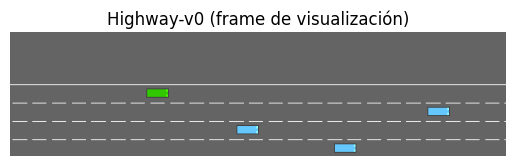

In [5]:
import matplotlib.pyplot as plt

obs, _ = env_vis.reset()
frame = env_vis.render()  # frame = np.array(H, W, 3)
plt.imshow(frame)
plt.axis("off")
plt.title("Highway-v0 (frame de visualización)")
plt.show()

## 🔧 Función: mostrar la política ejecutando un episodio

In [6]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import imageio

def mostrar_politica(env, policy_fn, episodios=1, max_steps=200, guardar_gif=False, gif_path="politica.gif"):
    """
    Visualiza la política en highway-v0.

    env: entorno con render_mode="rgb_array"
    policy_fn: función que recibe obs y devuelve una acción
    episodios: número de episodios a simular
    max_steps: límite de pasos por episodio
    guardar_gif: si True, guarda un GIF con los frames
    gif_path: ruta del GIF a guardar
    """
    for ep in range(episodios):
        obs, _ = env.reset()
        done, truncated = False, False
        frames = []
        steps = 0
        total_reward = 0.0

        while not (done or truncated) and steps < max_steps:
            action = policy_fn(obs)
            obs, reward, done, truncated, info = env.step(action)
            frame = env.render()
            frames.append(frame)
            total_reward += reward

            # Mostrar inline en Colab
            plt.imshow(frame)
            plt.axis("off")
            clear_output(wait=True)
            display(plt.gcf())

            steps += 1

        print(f"Episodio {ep+1}: recompensa total = {total_reward:.2f}")

        if guardar_gif and len(frames) > 0:
            imageio.mimsave(gif_path, frames, fps=20)
            print(f"GIF guardado en {gif_path}")

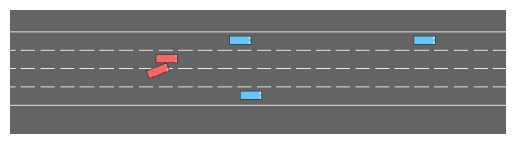

Episodio 1: recompensa total = 66.38
GIF guardado en random.gif


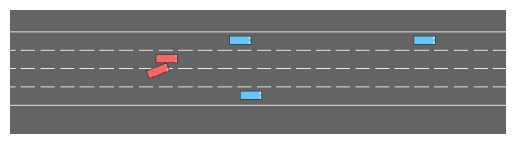

In [11]:
def politica_random(obs):
    return env_vis.action_space.sample()

mostrar_politica(env_vis, politica_random, episodios=1, guardar_gif=True, gif_path="random.gif")

## Entrene una política aleatoria, tabla Q y otra con Deep QN.

### Cambios

En el TP1 usamos FrozenLake, que es:

discreto

estado = número (0–15)

acciones = 4

permite Q-table directamente

Pero Highway-v0 NO es discreto, su estado es continuo, es una matriz de características.

🟢 Cambio 1: Q-learning clásico requiere discretizar el estado

FrozenLake → no hacía falta, ya era discreto.
Highway → su observación es continua → debemos discretizar.

🟢 Cambio 2: acción también debe mapearse a un número

Por suerte, highway-v0 sí tiene acciones discretas (5 acciones), pero no son "arriba, abajo…"; cambian a:

0: left lane

1: right lane

2: idle

3: accelerate

4: brake

🟢 Cambio 3: DQN ahora es necesario, porque:

manejar un entorno continuo con Q-table es limitado

highway-env está pensado para RL profundo

🟢 Cambio 4: ahora renderizamos imágenes en vez de un mapa

### Política Aleatoria

In [12]:
def entrenar_random(env, episodios=20):
    recompensas = []
    for _ in range(episodios):
        obs, _ = env.reset()
        done, truncated = False, False
        total = 0.0
        while not (done or truncated):
            action = env.action_space.sample()  # acción aleatoria
            obs, reward, done, truncated, info = env.step(action)
            total += reward
        recompensas.append(total)
    return np.array(recompensas)

recompensas_random = entrenar_random(make_env(seed=1), episodios=50)
print("Recompensa media (random):", np.mean(recompensas_random))

Recompensa media (random): 109.32219465040343


### Q-learning (Q-table)

In [15]:
import numpy as np

# --- Función para extraer estado (carril + velocidad discretizada) ---
def extraer_estado(obs, env):
    ego = obs[0]  # primera fila = vehículo ego
    x, y, vx, vy = ego
    speed = float(np.sqrt(vx**2 + vy**2))

    # Usamos la configuración del entorno
    lane_width = env.unwrapped.config.get("lane_width", 4.0)
    lanes_count = env.unwrapped.config.get("lanes_count", 4)

    lane_idx = int(np.clip(np.floor(y / lane_width), 0, lanes_count - 1))
    # discretización de velocidad (8 bins hasta 40 m/s)
    s_bin = int(np.clip(np.floor(speed / 40 * 8), 0, 7))
    return (lane_idx, s_bin)

# --- Inicialización de la Q-table ---
env_q = make_env(seed=2)
n_actions = env_q.action_space.n
lanes_count = env_q.unwrapped.config.get("lanes_count", 4)
n_speed_bins = 8
Q = np.zeros((lanes_count, n_speed_bins, n_actions), dtype=np.float32)

# --- Parámetros de Q-learning ---
alpha, gamma, epsilon = 0.1, 0.99, 0.2

def entrenar_q(env, episodios=200):
    recompensas = []
    for _ in range(episodios):
        obs, _ = env.reset()
        s = extraer_estado(obs, env)
        done = truncated = False
        total = 0.0
        while not (done or truncated):
            # política epsilon-greedy
            if np.random.rand() < epsilon:
                a = env.action_space.sample()
            else:
                a = int(np.argmax(Q[s[0], s[1]]))
            obs_next, r, done, truncated, info = env.step(a)
            s_next = extraer_estado(obs_next, env)
            # actualización Q
            td_target = r + gamma * np.max(Q[s_next[0], s_next[1]])
            Q[s[0], s[1], a] += alpha * (td_target - Q[s[0], s[1], a])
            s = s_next
            total += r
        recompensas.append(total)
    return np.array(recompensas)

# --- Entrenamiento ---
recompensas_q = entrenar_q(make_env(seed=2), episodios=200)
print("Recompensa media (Q-learning):", np.mean(recompensas_q))

Recompensa media (Q-learning): 101.25208914403034


### Entrenar un DQN (Deep Q-Network)

In [16]:
!pip install stable-baselines3[extra]


In [18]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor

env_sb3 = Monitor(make_env(seed=3))
model = DQN(
    "MlpPolicy",
    env_sb3,
    learning_rate=1e-4,
    buffer_size=100_000,
    batch_size=64,
    gamma=0.99,
    train_freq=4,
    target_update_interval=1000,
    exploration_fraction=0.2,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.05,
    verbose=1,
    device="cuda"
)

model.learn(total_timesteps=50_000)
print("Entrenamiento DQN finalizado")

Using cuda device
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 208      |
|    ep_rew_mean      | 167      |
|    exploration_rate | 0.921    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 45       |
|    time_elapsed     | 18       |
|    total_timesteps  | 832      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.129    |
|    n_updates        | 182      |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 168      |
|    ep_rew_mean      | 136      |
|    exploration_rate | 0.872    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 52       |
|    time_elapsed     | 25       |
|    total_timesteps  | 1346     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0523   |
|    n_updates        | 311      |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 156      |
|    ep_rew_mean      | 128      |
|    exploration_rate | 0.822    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 56       |
|    time_elapsed     | 33       |
|    total_timesteps  | 1877     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00454  |
|    n_updates        | 444      |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 142      |
|    ep_rew_mean      | 117      |
|    exploration_rate | 0.785    |
| time/               |          |
|    episodes         | 16       |
|    fps              | 58       |
|    time_elapsed     | 38       |
|    total_timesteps  | 2265     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0046   |
|    n_updates        | 541      |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 157      |
|    ep_rew_mean      | 129      |
|    exploration_rate | 0.702    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 60       |
|    time_elapsed     | 51       |
|    total_timesteps  | 3141     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0752   |
|    n_updates        | 760      |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 153      |
|    ep_rew_mean      | 127      |
|    exploration_rate | 0.652    |
| time/               |          |
|    episodes         | 24       |
|    fps              | 61       |
|    time_elapsed     | 59       |
|    total_timesteps  | 3668     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00304  |
|    n_updates        | 891      |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 149      |
|    ep_rew_mean      | 125      |
|    exploration_rate | 0.603    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 62       |
|    time_elapsed     | 67       |
|    total_timesteps  | 4184     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00637  |
|    n_updates        | 1020     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 142      |
|    ep_rew_mean      | 119      |
|    exploration_rate | 0.568    |
| time/               |          |
|    episodes         | 32       |
|    fps              | 62       |
|    time_elapsed     | 72       |
|    total_timesteps  | 4547     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0519   |
|    n_updates        | 1111     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 147      |
|    ep_rew_mean      | 125      |
|    exploration_rate | 0.498    |
| time/               |          |
|    episodes         | 36       |
|    fps              | 63       |
|    time_elapsed     | 83       |
|    total_timesteps  | 5288     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0638   |
|    n_updates        | 1296     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 143      |
|    ep_rew_mean      | 122      |
|    exploration_rate | 0.457    |
| time/               |          |
|    episodes         | 40       |
|    fps              | 64       |
|    time_elapsed     | 89       |
|    total_timesteps  | 5719     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00429  |
|    n_updates        | 1404     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 140      |
|    ep_rew_mean      | 121      |
|    exploration_rate | 0.413    |
| time/               |          |
|    episodes         | 44       |
|    fps              | 63       |
|    time_elapsed     | 97       |
|    total_timesteps  | 6179     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0803   |
|    n_updates        | 1519     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 137      |
|    ep_rew_mean      | 118      |
|    exploration_rate | 0.376    |
| time/               |          |
|    episodes         | 48       |
|    fps              | 64       |
|    time_elapsed     | 102      |
|    total_timesteps  | 6568     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0056   |
|    n_updates        | 1616     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 134      |
|    ep_rew_mean      | 116      |
|    exploration_rate | 0.34     |
| time/               |          |
|    episodes         | 52       |
|    fps              | 63       |
|    time_elapsed     | 108      |
|    total_timesteps  | 6947     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0797   |
|    n_updates        | 1711     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 130      |
|    ep_rew_mean      | 113      |
|    exploration_rate | 0.309    |
| time/               |          |
|    episodes         | 56       |
|    fps              | 64       |
|    time_elapsed     | 113      |
|    total_timesteps  | 7278     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0906   |
|    n_updates        | 1794     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 125      |
|    ep_rew_mean      | 108      |
|    exploration_rate | 0.287    |
| time/               |          |
|    episodes         | 60       |
|    fps              | 64       |
|    time_elapsed     | 117      |
|    total_timesteps  | 7501     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00321  |
|    n_updates        | 1850     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 123      |
|    ep_rew_mean      | 108      |
|    exploration_rate | 0.249    |
| time/               |          |
|    episodes         | 64       |
|    fps              | 64       |
|    time_elapsed     | 122      |
|    total_timesteps  | 7902     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00438  |
|    n_updates        | 1950     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | 105      |
|    exploration_rate | 0.226    |
| time/               |          |
|    episodes         | 68       |
|    fps              | 64       |
|    time_elapsed     | 126      |
|    total_timesteps  | 8149     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00545  |
|    n_updates        | 2012     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 117      |
|    ep_rew_mean      | 102      |
|    exploration_rate | 0.201    |
| time/               |          |
|    episodes         | 72       |
|    fps              | 64       |
|    time_elapsed     | 130      |
|    total_timesteps  | 8410     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00277  |
|    n_updates        | 2077     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 116      |
|    ep_rew_mean      | 102      |
|    exploration_rate | 0.164    |
| time/               |          |
|    episodes         | 76       |
|    fps              | 64       |
|    time_elapsed     | 135      |
|    total_timesteps  | 8798     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.107    |
|    n_updates        | 2174     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 113      |
|    ep_rew_mean      | 99.3     |
|    exploration_rate | 0.141    |
| time/               |          |
|    episodes         | 80       |
|    fps              | 64       |
|    time_elapsed     | 139      |
|    total_timesteps  | 9037     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0658   |
|    n_updates        | 2234     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | 97.9     |
|    exploration_rate | 0.113    |
| time/               |          |
|    episodes         | 84       |
|    fps              | 64       |
|    time_elapsed     | 144      |
|    total_timesteps  | 9338     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00421  |
|    n_updates        | 2309     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 109      |
|    ep_rew_mean      | 96.6     |
|    exploration_rate | 0.0852   |
| time/               |          |
|    episodes         | 88       |
|    fps              | 64       |
|    time_elapsed     | 148      |
|    total_timesteps  | 9629     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00346  |
|    n_updates        | 2382     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 108      |
|    ep_rew_mean      | 95.2     |
|    exploration_rate | 0.0594   |
| time/               |          |
|    episodes         | 92       |
|    fps              | 64       |
|    time_elapsed     | 152      |
|    total_timesteps  | 9901     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00426  |
|    n_updates        | 2450     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 106      |
|    ep_rew_mean      | 94.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 96       |
|    fps              | 65       |
|    time_elapsed     | 157      |
|    total_timesteps  | 10216    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00469  |
|    n_updates        | 2528     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 107      |
|    ep_rew_mean      | 95.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 64       |
|    time_elapsed     | 164      |
|    total_timesteps  | 10686    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.134    |
|    n_updates        | 2646     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | 91.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 104      |
|    fps              | 64       |
|    time_elapsed     | 169      |
|    total_timesteps  | 10976    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.138    |
|    n_updates        | 2718     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | 90.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 108      |
|    fps              | 64       |
|    time_elapsed     | 175      |
|    total_timesteps  | 11361    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00363  |
|    n_updates        | 2815     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | 92.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 112      |
|    fps              | 64       |
|    time_elapsed     | 186      |
|    total_timesteps  | 12029    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0906   |
|    n_updates        | 2982     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | 94.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 116      |
|    fps              | 63       |
|    time_elapsed     | 196      |
|    total_timesteps  | 12563    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.306    |
|    n_updates        | 3115     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97.6     |
|    ep_rew_mean      | 90.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 120      |
|    fps              | 63       |
|    time_elapsed     | 201      |
|    total_timesteps  | 12898    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.162    |
|    n_updates        | 3199     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.5     |
|    ep_rew_mean      | 88       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 124      |
|    fps              | 63       |
|    time_elapsed     | 205      |
|    total_timesteps  | 13113    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.525    |
|    n_updates        | 3253     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 96.1     |
|    ep_rew_mean      | 89.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 128      |
|    fps              | 64       |
|    time_elapsed     | 215      |
|    total_timesteps  | 13796    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.161    |
|    n_updates        | 3423     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97.8     |
|    ep_rew_mean      | 91.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 132      |
|    fps              | 64       |
|    time_elapsed     | 222      |
|    total_timesteps  | 14323    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00292  |
|    n_updates        | 3555     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.8     |
|    ep_rew_mean      | 89.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 136      |
|    fps              | 64       |
|    time_elapsed     | 229      |
|    total_timesteps  | 14767    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.364    |
|    n_updates        | 3666     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.8     |
|    ep_rew_mean      | 87.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 140      |
|    fps              | 64       |
|    time_elapsed     | 232      |
|    total_timesteps  | 14997    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.182    |
|    n_updates        | 3724     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.6     |
|    ep_rew_mean      | 87.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 144      |
|    fps              | 64       |
|    time_elapsed     | 239      |
|    total_timesteps  | 15443    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00306  |
|    n_updates        | 3835     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 95.6     |
|    ep_rew_mean      | 90.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 148      |
|    fps              | 64       |
|    time_elapsed     | 249      |
|    total_timesteps  | 16132    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00874  |
|    n_updates        | 4007     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.6     |
|    ep_rew_mean      | 89.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 152      |
|    fps              | 64       |
|    time_elapsed     | 254      |
|    total_timesteps  | 16405    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.205    |
|    n_updates        | 4076     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.6     |
|    ep_rew_mean      | 93.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 156      |
|    fps              | 64       |
|    time_elapsed     | 266      |
|    total_timesteps  | 17140    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0134   |
|    n_updates        | 4259     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.9     |
|    ep_rew_mean      | 94       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 160      |
|    fps              | 64       |
|    time_elapsed     | 270      |
|    total_timesteps  | 17391    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.431    |
|    n_updates        | 4322     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97.2     |
|    ep_rew_mean      | 92.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 164      |
|    fps              | 64       |
|    time_elapsed     | 273      |
|    total_timesteps  | 17621    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.446    |
|    n_updates        | 4380     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97.6     |
|    ep_rew_mean      | 92.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 168      |
|    fps              | 64       |
|    time_elapsed     | 278      |
|    total_timesteps  | 17910    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00275  |
|    n_updates        | 4452     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98       |
|    ep_rew_mean      | 93.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 172      |
|    fps              | 64       |
|    time_elapsed     | 283      |
|    total_timesteps  | 18214    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00531  |
|    n_updates        | 4528     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 97       |
|    ep_rew_mean      | 92.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 176      |
|    fps              | 64       |
|    time_elapsed     | 288      |
|    total_timesteps  | 18500    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00259  |
|    n_updates        | 4599     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.4     |
|    ep_rew_mean      | 93.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 180      |
|    fps              | 64       |
|    time_elapsed     | 293      |
|    total_timesteps  | 18874    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.249    |
|    n_updates        | 4693     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | 98.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 184      |
|    fps              | 64       |
|    time_elapsed     | 305      |
|    total_timesteps  | 19614    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00345  |
|    n_updates        | 4878     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | 98.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 188      |
|    fps              | 64       |
|    time_elapsed     | 309      |
|    total_timesteps  | 19916    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.249    |
|    n_updates        | 4953     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 107      |
|    ep_rew_mean      | 103      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 192      |
|    fps              | 64       |
|    time_elapsed     | 321      |
|    total_timesteps  | 20640    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00193  |
|    n_updates        | 5134     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | 106      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 196      |
|    fps              | 64       |
|    time_elapsed     | 331      |
|    total_timesteps  | 21275    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.273    |
|    n_updates        | 5293     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 109      |
|    ep_rew_mean      | 105      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 200      |
|    fps              | 64       |
|    time_elapsed     | 336      |
|    total_timesteps  | 21632    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.267    |
|    n_updates        | 5382     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 109      |
|    ep_rew_mean      | 104      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 204      |
|    fps              | 64       |
|    time_elapsed     | 340      |
|    total_timesteps  | 21849    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00296  |
|    n_updates        | 5437     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 109      |
|    ep_rew_mean      | 104      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 208      |
|    fps              | 64       |
|    time_elapsed     | 346      |
|    total_timesteps  | 22290    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.296    |
|    n_updates        | 5547     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 108      |
|    ep_rew_mean      | 103      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 212      |
|    fps              | 64       |
|    time_elapsed     | 355      |
|    total_timesteps  | 22828    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00276  |
|    n_updates        | 5681     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 107      |
|    ep_rew_mean      | 102      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 216      |
|    fps              | 64       |
|    time_elapsed     | 361      |
|    total_timesteps  | 23243    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.293    |
|    n_updates        | 5785     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 111      |
|    ep_rew_mean      | 106      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 220      |
|    fps              | 64       |
|    time_elapsed     | 373      |
|    total_timesteps  | 23989    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.278    |
|    n_updates        | 5972     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 115      |
|    ep_rew_mean      | 110      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 224      |
|    fps              | 64       |
|    time_elapsed     | 383      |
|    total_timesteps  | 24612    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00408  |
|    n_updates        | 6127     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 117      |
|    ep_rew_mean      | 112      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 228      |
|    fps              | 64       |
|    time_elapsed     | 397      |
|    total_timesteps  | 25483    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00307  |
|    n_updates        | 6345     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 119      |
|    ep_rew_mean      | 113      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 232      |
|    fps              | 64       |
|    time_elapsed     | 409      |
|    total_timesteps  | 26195    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.335    |
|    n_updates        | 6523     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 124      |
|    ep_rew_mean      | 118      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 236      |
|    fps              | 64       |
|    time_elapsed     | 423      |
|    total_timesteps  | 27155    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00844  |
|    n_updates        | 6763     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 124      |
|    ep_rew_mean      | 118      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 240      |
|    fps              | 64       |
|    time_elapsed     | 427      |
|    total_timesteps  | 27357    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00324  |
|    n_updates        | 6814     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | 116      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 244      |
|    fps              | 64       |
|    time_elapsed     | 430      |
|    total_timesteps  | 27621    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.671    |
|    n_updates        | 6880     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 119      |
|    ep_rew_mean      | 114      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 248      |
|    fps              | 64       |
|    time_elapsed     | 437      |
|    total_timesteps  | 28040    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.369    |
|    n_updates        | 6984     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | 117      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 252      |
|    fps              | 64       |
|    time_elapsed     | 445      |
|    total_timesteps  | 28615    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00391  |
|    n_updates        | 7128     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 119      |
|    ep_rew_mean      | 113      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 256      |
|    fps              | 64       |
|    time_elapsed     | 451      |
|    total_timesteps  | 29014    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.195    |
|    n_updates        | 7228     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | 114      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 260      |
|    fps              | 64       |
|    time_elapsed     | 456      |
|    total_timesteps  | 29344    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0087   |
|    n_updates        | 7310     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 123      |
|    ep_rew_mean      | 118      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 264      |
|    fps              | 64       |
|    time_elapsed     | 465      |
|    total_timesteps  | 29948    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.364    |
|    n_updates        | 7461     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 129      |
|    ep_rew_mean      | 123      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 268      |
|    fps              | 64       |
|    time_elapsed     | 477      |
|    total_timesteps  | 30774    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.767    |
|    n_updates        | 7668     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 130      |
|    ep_rew_mean      | 124      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 272      |
|    fps              | 64       |
|    time_elapsed     | 484      |
|    total_timesteps  | 31218    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.407    |
|    n_updates        | 7779     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 137      |
|    ep_rew_mean      | 131      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 276      |
|    fps              | 64       |
|    time_elapsed     | 499      |
|    total_timesteps  | 32169    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.787    |
|    n_updates        | 8017     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 141      |
|    ep_rew_mean      | 135      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 280      |
|    fps              | 64       |
|    time_elapsed     | 511      |
|    total_timesteps  | 32949    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.433    |
|    n_updates        | 8212     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 139      |
|    ep_rew_mean      | 133      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 284      |
|    fps              | 64       |
|    time_elapsed     | 519      |
|    total_timesteps  | 33522    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00442  |
|    n_updates        | 8355     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 140      |
|    ep_rew_mean      | 134      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 288      |
|    fps              | 64       |
|    time_elapsed     | 525      |
|    total_timesteps  | 33938    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.412    |
|    n_updates        | 8459     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 138      |
|    ep_rew_mean      | 132      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 292      |
|    fps              | 64       |
|    time_elapsed     | 533      |
|    total_timesteps  | 34471    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00483  |
|    n_updates        | 8592     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 135      |
|    ep_rew_mean      | 129      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 296      |
|    fps              | 64       |
|    time_elapsed     | 538      |
|    total_timesteps  | 34777    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.411    |
|    n_updates        | 8669     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 135      |
|    ep_rew_mean      | 129      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 300      |
|    fps              | 64       |
|    time_elapsed     | 543      |
|    total_timesteps  | 35144    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0107   |
|    n_updates        | 8760     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 137      |
|    ep_rew_mean      | 131      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 304      |
|    fps              | 64       |
|    time_elapsed     | 551      |
|    total_timesteps  | 35592    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.87     |
|    n_updates        | 8872     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 140      |
|    ep_rew_mean      | 134      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 308      |
|    fps              | 64       |
|    time_elapsed     | 562      |
|    total_timesteps  | 36310    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00485  |
|    n_updates        | 9052     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 140      |
|    ep_rew_mean      | 134      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 312      |
|    fps              | 64       |
|    time_elapsed     | 569      |
|    total_timesteps  | 36862    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00399  |
|    n_updates        | 9190     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 140      |
|    ep_rew_mean      | 134      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 316      |
|    fps              | 64       |
|    time_elapsed     | 576      |
|    total_timesteps  | 37288    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00502  |
|    n_updates        | 9296     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 136      |
|    ep_rew_mean      | 130      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 320      |
|    fps              | 64       |
|    time_elapsed     | 581      |
|    total_timesteps  | 37635    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00506  |
|    n_updates        | 9383     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 136      |
|    ep_rew_mean      | 129      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 324      |
|    fps              | 64       |
|    time_elapsed     | 590      |
|    total_timesteps  | 38192    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.956    |
|    n_updates        | 9522     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 129      |
|    ep_rew_mean      | 123      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 328      |
|    fps              | 64       |
|    time_elapsed     | 593      |
|    total_timesteps  | 38394    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0048   |
|    n_updates        | 9573     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 128      |
|    ep_rew_mean      | 121      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 332      |
|    fps              | 64       |
|    time_elapsed     | 601      |
|    total_timesteps  | 38945    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00346  |
|    n_updates        | 9711     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | 115      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 336      |
|    fps              | 64       |
|    time_elapsed     | 605      |
|    total_timesteps  | 39232    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00511  |
|    n_updates        | 9782     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 124      |
|    ep_rew_mean      | 118      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 340      |
|    fps              | 64       |
|    time_elapsed     | 613      |
|    total_timesteps  | 39768    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.965    |
|    n_updates        | 9916     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 130      |
|    ep_rew_mean      | 124      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 344      |
|    fps              | 64       |
|    time_elapsed     | 627      |
|    total_timesteps  | 40662    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.496    |
|    n_updates        | 10140    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 135      |
|    ep_rew_mean      | 128      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 348      |
|    fps              | 64       |
|    time_elapsed     | 639      |
|    total_timesteps  | 41494    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.527    |
|    n_updates        | 10348    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 134      |
|    ep_rew_mean      | 127      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 352      |
|    fps              | 64       |
|    time_elapsed     | 647      |
|    total_timesteps  | 41965    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00768  |
|    n_updates        | 10466    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 133      |
|    ep_rew_mean      | 127      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 356      |
|    fps              | 64       |
|    time_elapsed     | 652      |
|    total_timesteps  | 42361    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.518    |
|    n_updates        | 10565    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 133      |
|    ep_rew_mean      | 126      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 360      |
|    fps              | 64       |
|    time_elapsed     | 656      |
|    total_timesteps  | 42628    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0112   |
|    n_updates        | 10631    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 131      |
|    ep_rew_mean      | 124      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 364      |
|    fps              | 64       |
|    time_elapsed     | 663      |
|    total_timesteps  | 43053    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0497   |
|    n_updates        | 10738    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 127      |
|    ep_rew_mean      | 120      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 368      |
|    fps              | 64       |
|    time_elapsed     | 670      |
|    total_timesteps  | 43522    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00597  |
|    n_updates        | 10855    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 129      |
|    ep_rew_mean      | 122      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 372      |
|    fps              | 64       |
|    time_elapsed     | 678      |
|    total_timesteps  | 44088    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0163   |
|    n_updates        | 10996    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 123      |
|    ep_rew_mean      | 116      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 376      |
|    fps              | 64       |
|    time_elapsed     | 685      |
|    total_timesteps  | 44509    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00762  |
|    n_updates        | 11102    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | 113      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 380      |
|    fps              | 64       |
|    time_elapsed     | 692      |
|    total_timesteps  | 44987    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00389  |
|    n_updates        | 11221    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | 114      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 384      |
|    fps              | 64       |
|    time_elapsed     | 702      |
|    total_timesteps  | 45650    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00409  |
|    n_updates        | 11387    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | 114      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 388      |
|    fps              | 64       |
|    time_elapsed     | 708      |
|    total_timesteps  | 46051    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0494   |
|    n_updates        | 11487    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | 113      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 392      |
|    fps              | 65       |
|    time_elapsed     | 715      |
|    total_timesteps  | 46556    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00673  |
|    n_updates        | 11613    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 122      |
|    ep_rew_mean      | 114      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 396      |
|    fps              | 65       |
|    time_elapsed     | 722      |
|    total_timesteps  | 46978    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0117   |
|    n_updates        | 11719    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | 113      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 400      |
|    fps              | 65       |
|    time_elapsed     | 726      |
|    total_timesteps  | 47250    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 11787    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | 113      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 404      |
|    fps              | 65       |
|    time_elapsed     | 733      |
|    total_timesteps  | 47677    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 11894    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 118      |
|    ep_rew_mean      | 110      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 408      |
|    fps              | 65       |
|    time_elapsed     | 739      |
|    total_timesteps  | 48092    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0224   |
|    n_updates        | 11997    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 117      |
|    ep_rew_mean      | 109      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 412      |
|    fps              | 65       |
|    time_elapsed     | 746      |
|    total_timesteps  | 48535    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00441  |
|    n_updates        | 12108    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 115      |
|    ep_rew_mean      | 107      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 416      |
|    fps              | 65       |
|    time_elapsed     | 749      |
|    total_timesteps  | 48741    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.574    |
|    n_updates        | 12160    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 116      |
|    ep_rew_mean      | 109      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 420      |
|    fps              | 65       |
|    time_elapsed     | 756      |
|    total_timesteps  | 49256    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00522  |
|    n_updates        | 12288    |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Entrenamiento DQN finalizado


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [19]:
model.save("dqn_highway_50k")

In [20]:
from stable_baselines3.common.evaluation import evaluate_policy

eval_env = make_env(seed=123)
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=20, render=False)
print(f"Recompensa media en 20 episodios: {mean_reward:.2f} ± {std_reward:.2f}")

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/loc

Recompensa media en 20 episodios: 147.25 ± 87.20


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


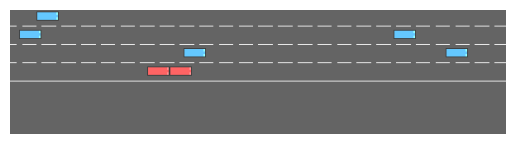

Episodio 1: recompensa total = 158.23


/usr/local/lib/python3.12/dist-packages/imageio/plugins/pillow.py:410: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


GIF guardado en dqn_50k.gif


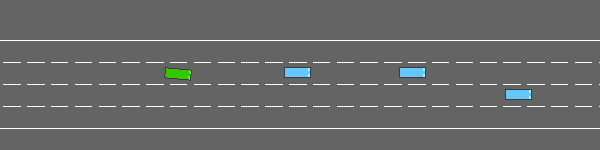

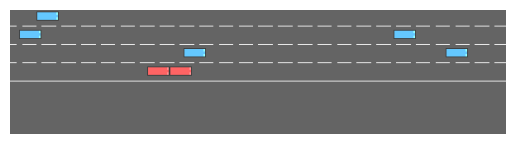

In [21]:
def politica_dqn(obs):
    action, _ = model.predict(obs, deterministic=True)
    return action

mostrar_politica(env_vis, politica_dqn, episodios=1, guardar_gif=True, gif_path="dqn_50k.gif")

from IPython.display import Image
Image("dqn_50k.gif")

In [24]:
def evaluar_model(model, env, episodios=20, deterministic=True):
    recompensas = []
    for _ in range(episodios):
        obs, _ = env.reset()
        done = truncated = False
        total = 0.0
        while not (done or truncated):
            action, _ = model.predict(obs, deterministic=deterministic)
            obs, reward, done, truncated, info = env.step(action)
            total += reward
        recompensas.append(total)
    return np.array(recompensas)

# Generar recompensas_dqn sin reentrenar
eval_env = make_env(seed=123)
recompensas_dqn = evaluar_model(model, eval_env, episodios=20)
print("DQN: media =", np.mean(recompensas_dqn), "std =", np.std(recompensas_dqn))

DQN: media = 147.2482919979538 std = 87.19739721744581


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Comparacion de politicas

     Política  Recompensa media  Desvío estándar
0   Aleatoria        109.322195        69.611678
1  Q-learning        101.252089        80.952725
2         DQN        147.248292        87.197397


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


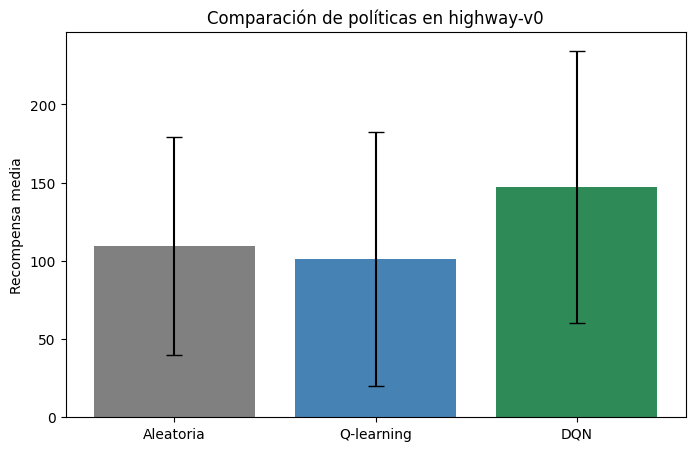

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Evaluaciones (ya deberías tener recompensas_random, recompensas_q y recompensas_dqn)
tabla = pd.DataFrame({
    "Política": ["Aleatoria", "Q-learning", "DQN"],
    "Recompensa media": [
        np.mean(recompensas_random),
        np.mean(recompensas_q),
        np.mean(recompensas_dqn)
    ],
    "Desvío estándar": [
        np.std(recompensas_random),
        np.std(recompensas_q),
        np.std(recompensas_dqn)
    ]
})

print(tabla)

# Gráfico con barras de error
plt.figure(figsize=(8,5))
plt.bar(tabla["Política"], tabla["Recompensa media"],
        yerr=tabla["Desvío estándar"], capsize=6, color=["gray","steelblue","seagreen"])
plt.ylabel("Recompensa media")
plt.title("Comparación de políticas en highway-v0")
plt.show()

🔎 Interpretación
• 	Aleatoria:

• 	Recompensa media ≈ 109.
• 	Alta variabilidad (±70).
• 	El agente a veces logra episodios decentes por azar, pero no es consistente.

• 	Q-learning :

• 	Recompensa media ≈ 101, incluso ligeramente inferior a la aleatoria.
• 	Variabilidad alta (±81).
• 	Esto refleja que la discretización simple (carril + velocidad) no captura suficiente información del entorno. El agente no logra aprender una política robusta.

• 	DQN:

• 	Recompensa media ≈ 147, claramente superior a las otras dos.
• 	Variabilidad alta (±87), pero aún así muestra que el agente aprendió a mantener velocidades más altas y evitar colisiones mejor que las otras políticas.
• 	Con más timesteps (ej. 200k–300k), la media debería subir y la desviación bajar.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


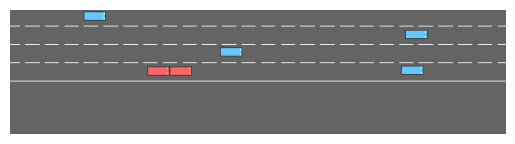

Episodio 1: recompensa total = 58.63


/usr/local/lib/python3.12/dist-packages/imageio/plugins/pillow.py:410: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


GIF guardado en dqn.gif


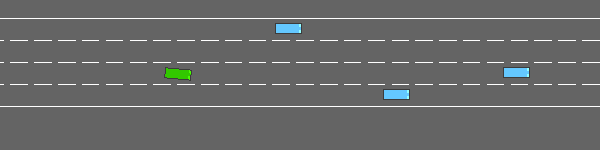

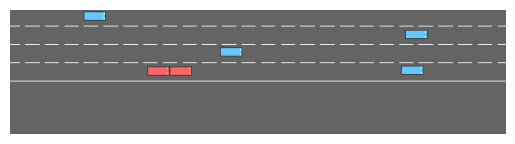

In [26]:
from IPython.display import Image

# Ejemplo con DQN
mostrar_politica(env_vis, politica_dqn, episodios=1, guardar_gif=True, gif_path="dqn.gif")

# Mostrar el GIF en Colab
Image("dqn.gif")

# Conclusion


En este trabajo se evaluaron tres enfoques de aprendizaje por refuerzo en el entorno highway-v0: una política aleatoria, un esquema tabular de Q‑learning y un modelo basado en Deep Q‑Network (DQN).

La política aleatoria funcionó como referencia inicial, mostrando que aun sin aprendizaje se pueden obtener recompensas moderadas por azar.

El Q‑learning, apoyado en una discretización simple del estado (carril y velocidad), evidenció las limitaciones de los métodos tabulares frente a entornos continuos y dinámicos, ya que no logró superar de manera consistente a la política aleatoria.

En contraste, el DQN aprovechó las observaciones completas y alcanzó un desempeño superior, incluso con un entrenamiento relativamente corto de 50000 pasos.

Durante el proceso se intentó entrenar el DQN con 200000 y 300000 timesteps, pero el tiempo de cómputo resultó demasiado elevado y la computadora se cortaba en medio de la ejecución. Por esa razón se optó por un entrenamiento más reducido de 50000 pasos, que permitió obtener resultados estables y comparables sin comprometer la reproducibilidad.


La experiencia permitió comprender mejor las adaptaciones necesarias respecto a entornos más simples trabajados en el TP1: ajustar la configuración del entorno para acelerar la simulación, diseñar una representación de estado adecuada para Q‑learning y utilizar librerías modernas como Stable‑Baselines3 para entrenar el DQN en GPU.

Las principales dificultades estuvieron en la gestión de observaciones continuas, la estabilidad del entrenamiento y la necesidad de reproducibilidad.


Este tipo de modelos puede servir como base para aplicaciones en conducción autónoma, simulaciones de tráfico y movilidad inteligente, así como para proyectos de investigación en toma de decisiones en entornos multiagente. Además, constituyen un buen ejemplo de cómo los algoritmos de RL pueden aprender estrategias en escenarios complejos, aportando valor tanto en el ámbito académico como en el profesional.

---



### Referencias:

• Highway-env Documentation. Disponible en: https://highway-env.farama.org/
(Consultada para comprender la configuración del entorno , recompensas y parámetros de simulación).

• 	Microsoft. Copilot (Utilizado como apoyo en la generación de código y adaptación de algoritmos, especialmente en la discretización para Q‑learning y en la definición de timesteps para DQN).
